# Multi-View Composition

When visualizing a number of different data fields, we might be tempted to use as many visual encoding channels as we can: `x`, `y`, `color`, `size`, `shape`, and so on. However, as the number of encoding channels increases, a chart can rapidly become cluttered and difficult to read. An alternative to "over-loading" a single chart is to instead _compose multiple charts_ in a way that facilitates rapid comparisons.

In this notebook, we will examine a variety of operations for _multi-view composition_:

- _layer_: place compatible charts directly on top of each other,
- _facet_: partition data into multiple charts, organized in rows or columns,
- _concatenate_: position arbitrary charts within a shared layout, and
- _repeat_: take a base chart specification and apply it to multiple data fields.

We'll then look at how these operations form a _view composition algebra_, in which the operations can be combined to build a variety of complex multi-view displays.

_This notebook is part of the [data visualization curriculum](https://github.com/uwdata/visualization-curriculum)._

In [1]:
import pandas as pd
import altair as alt

## Weather Data

We will be visualizing weather statistics for the U.S. cities of Seattle and New York. Let's load the dataset and peek at the first and last 10 rows:

In [2]:
weather = 'https://vega.github.io/vega-datasets/data/weather.csv'

In [3]:
df = pd.read_csv(weather)
df.head(10)

,location,date,precipitation,temp_max,temp_min,wind,weather
0,Seattle,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,Seattle,2012-01-02,10.9,10.6,2.8,4.5,rain
2,Seattle,2012-01-03,0.8,11.7,7.2,2.3,rain
3,Seattle,2012-01-04,20.3,12.2,5.6,4.7,rain
4,Seattle,2012-01-05,1.3,8.9,2.8,6.1,rain
5,Seattle,2012-01-06,2.5,4.4,2.2,2.2,rain
6,Seattle,2012-01-07,0.0,7.2,2.8,2.3,rain
7,Seattle,2012-01-08,0.0,10.0,2.8,2.0,sun
8,Seattle,2012-01-09,4.3,9.4,5.0,3.4,rain
9,Seattle,2012-01-10,1.0,6.1,0.6,3.4,rain


In [4]:
df.tail(10)

,location,date,precipitation,temp_max,temp_min,wind,weather
2912,New York,2015-12-22,4.8,15.6,11.1,3.8,fog
2913,New York,2015-12-23,29.5,17.2,8.9,4.5,fog
2914,New York,2015-12-24,0.5,20.6,13.9,4.9,fog
2915,New York,2015-12-25,2.5,17.8,11.1,0.9,fog
2916,New York,2015-12-26,0.3,15.6,9.4,4.8,drizzle
2917,New York,2015-12-27,2.0,17.2,8.9,5.5,fog
2918,New York,2015-12-28,1.3,8.9,1.7,6.3,snow
2919,New York,2015-12-29,16.8,9.4,1.1,5.3,fog
2920,New York,2015-12-30,9.4,10.6,5.0,3.0,fog
2921,New York,2015-12-31,1.5,11.1,6.1,5.5,fog


We will create multi-view displays to examine weather within and across the cities.

## Layer

One of the most common ways of combining multiple charts is to *layer* marks on top of each other. If the underlying scale domains are compatible, we can merge them to form _shared axes_. If either of the `x` or `y` encodings is not compatible, we might instead create a _dual-axis chart_, which overlays marks using separate scales and axes.

### Shared Axes

Let's start by plotting the minimum and maximum average temperatures per month:

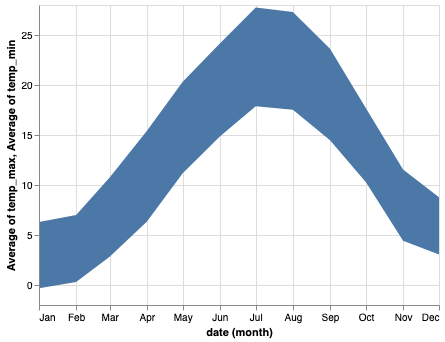

In [5]:
alt.Chart(weather).mark_area().encode(
  alt.X('month(date):T'),
  alt.Y('average(temp_max):Q'),
  alt.Y2('average(temp_min):Q')
)

_The plot shows us temperature ranges for each month over the entirety of our data. However, this is pretty misleading as it aggregates the measurements for both Seattle and New York!_

Let's subdivide the data by location using a color encoding, while also adjusting the mark opacity to accommodate overlapping areas:

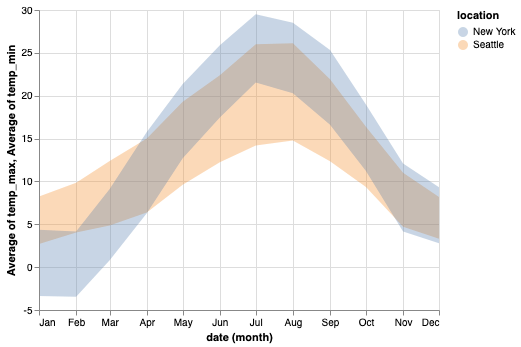

In [6]:
alt.Chart(weather).mark_area(opacity=0.3).encode(
  alt.X('month(date):T'),
  alt.Y('average(temp_max):Q'),
  alt.Y2('average(temp_min):Q'),
  alt.Color('location:N')
)

_We can see that Seattle is more temperate: warmer in the winter, and cooler in the summer._

In this case we've created a layered chart without any special features by simply subdividing the area marks by color. While the chart above shows us the temperature ranges, we might also want to emphasize the middle of the range.

Let's create a line chart showing the average temperature midpoint. We'll use a `calculate` transform to compute the midpoints between the minimum and maximum daily temperatures:

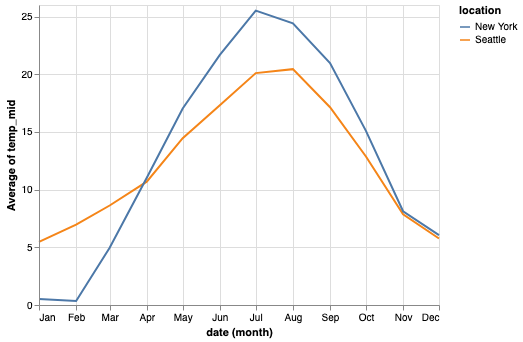

In [7]:
alt.Chart(weather).mark_line().transform_calculate(
  temp_mid='(+datum.temp_min + +datum.temp_max) / 2'
).encode(
  alt.X('month(date):T'),
  alt.Y('average(temp_mid):Q'),
  alt.Color('location:N')
)

_Aside_: note the use of `+datum.temp_min` within the calculate transform. As we are loading the data directly from a CSV file without any special parsing instructions, the temperature values may be internally represented as string values. Adding the  `+` in front of the value forces it to be treated as a number.

We'd now like to combine these charts by layering the midpoint lines over the range areas. Using the syntax `chart1 + chart2`, we can specify that we want a new layered chart in which `chart1` is the first layer and `chart2` is a second layer drawn on top:

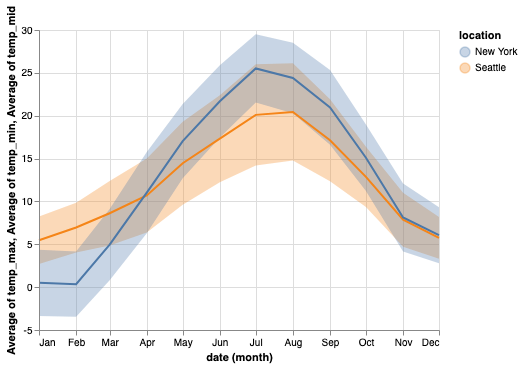

In [8]:
tempMinMax = alt.Chart(weather).mark_area(opacity=0.3).encode(
  alt.X('month(date):T'),
  alt.Y('average(temp_max):Q'),
  alt.Y2('average(temp_min):Q'),
  alt.Color('location:N')
)

tempMid = alt.Chart(weather).mark_line().transform_calculate(
  temp_mid='(+datum.temp_min + +datum.temp_max) / 2'
).encode(
  alt.X('month(date):T'),
  alt.Y('average(temp_mid):Q'),
  alt.Color('location:N')
)

tempMinMax + tempMid

_Now we have a multi-layer plot! However, the y-axis title (though informative) has become a bit long and unruly..._

Let's customize our axes to clean up the plot. If we set a custom axis title within one of the layers, it will automatically be used as a shared axis title for all the layers:

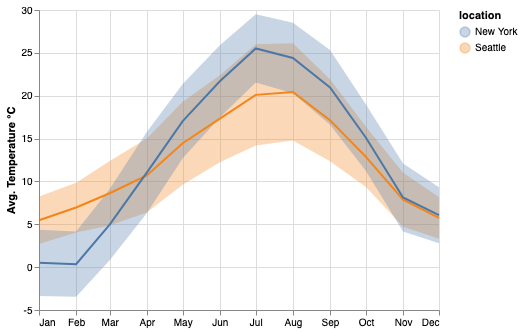

In [9]:
tempMinMax = alt.Chart(weather).mark_area(opacity=0.3).encode(
  alt.X('month(date):T', title=None, axis=alt.Axis(format='%b')),
  alt.Y('average(temp_max):Q', title='Avg. Temperature °C'),
  alt.Y2('average(temp_min):Q'),
  alt.Color('location:N')
)

tempMid = alt.Chart(weather).mark_line().transform_calculate(
  temp_mid='(+datum.temp_min + +datum.temp_max) / 2'
).encode(
  alt.X('month(date):T'),
  alt.Y('average(temp_mid):Q'),
  alt.Color('location:N')
)

tempMinMax + tempMid

_What happens if both layers have custom axis titles? Modify the code above to find out..._

Above used the `+` operator, a convenient shorthand for Altair's `layer` method. We can generate an identical layered chart using the `layer` method directly:

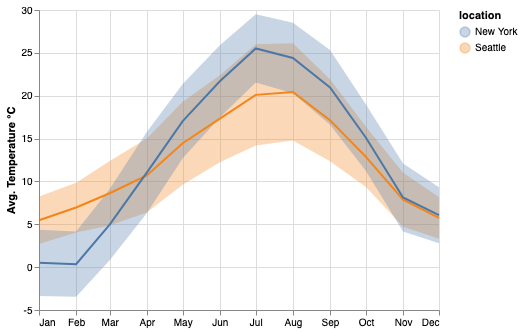

In [10]:
alt.layer(tempMinMax, tempMid)

Note that the order of inputs to a layer matters, as subsequent layers will be drawn on top of earlier layers. _Try swapping the order of the charts in the cells above. What happens? (Hint: look closely at the color of the `line` marks.)_

### Dual-Axis Charts

_Seattle has a reputation as a rainy city. Is that deserved?_

Let's look at precipitation alongside temperature to learn more. First let's create a base plot the shows average monthly precipitation in Seattle:

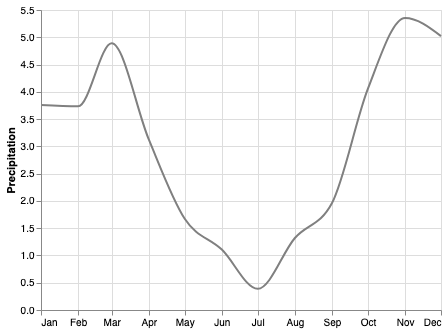

In [11]:
alt.Chart(weather).transform_filter(
  'datum.location == "Seattle"'
).mark_line(
  interpolate='monotone',
  stroke='grey'
).encode(
  alt.X('month(date):T', title=None),
  alt.Y('average(precipitation):Q', title='Precipitation')
)

To facilitate comparison with the temperature data, let's create a new layered chart. Here's what happens if we try to layer the charts as we did earlier:

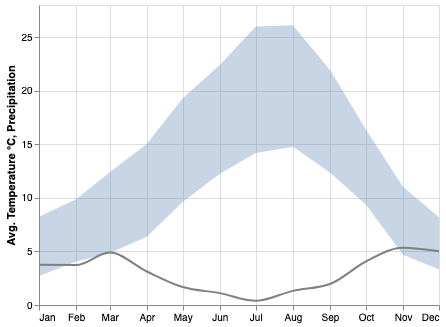

In [12]:
tempMinMax = alt.Chart(weather).transform_filter(
  'datum.location == "Seattle"'
).mark_area(opacity=0.3).encode(
  alt.X('month(date):T', title=None, axis=alt.Axis(format='%b')),
  alt.Y('average(temp_max):Q', title='Avg. Temperature °C'),
  alt.Y2('average(temp_min):Q')
)

precip = alt.Chart(weather).transform_filter(
  'datum.location == "Seattle"'
).mark_line(
  interpolate='monotone',
  stroke='grey'
).encode(
  alt.X('month(date):T'),
  alt.Y('average(precipitation):Q', title='Precipitation')
)

alt.layer(tempMinMax, precip)

_The precipitation values use a much smaller range of the y-axis then the temperatures!_

By default, layered charts use a *shared domain*: the values for the x-axis or y-axis are combined across all the layers to determine a shared extent. This default behavior assumes that the layered values have the same units. However, this doesn't hold up for this example, as we are combining temperature values (degrees Celsius) with precipitation values (inches)!

If we want to use different y-axis scales, we need to specify how we want Altair to *resolve* the data across layers. In this case, we want to resolve the y-axis `scale` domains to be `independent` rather than use a `shared` domain. The `Chart` object produced by a layer operator includes a `resolve_scale` method with which we can specify the desired resolution:

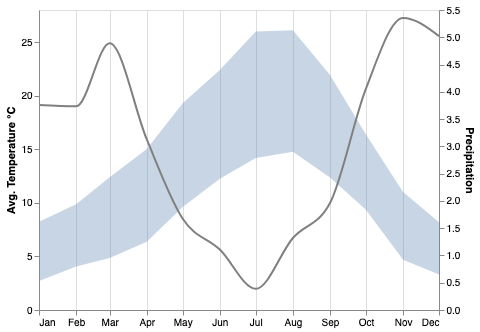

In [13]:
tempMinMax = alt.Chart(weather).transform_filter(
  'datum.location == "Seattle"'
).mark_area(opacity=0.3).encode(
  alt.X('month(date):T', title=None, axis=alt.Axis(format='%b')),
  alt.Y('average(temp_max):Q', title='Avg. Temperature °C'),
  alt.Y2('average(temp_min):Q')
)

precip = alt.Chart(weather).transform_filter(
  'datum.location == "Seattle"'
).mark_line(
  interpolate='monotone',
  stroke='grey'
).encode(
  alt.X('month(date):T'),
  alt.Y('average(precipitation):Q', title='Precipitation')
)

alt.layer(tempMinMax, precip).resolve_scale(y='independent')

_We can now see that autumn is the rainiest season in Seattle (peaking in November), complemented by dry summers._

You may have noticed some redundancy in our plot specifications above: both use the same dataset and the same filter to look at Seattle only. If you want, you can streamline the code a bit by providing the data and filter transform to the top-level layered chart. The individual layers will then inherit the data if they don't have their own data definitions:

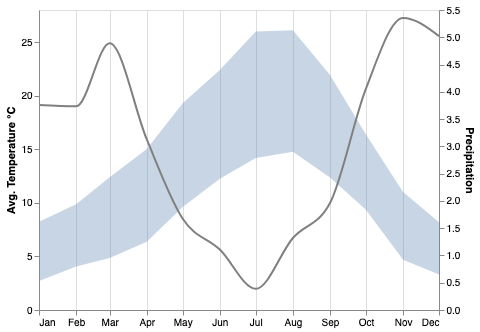

In [14]:
tempMinMax = alt.Chart().mark_area(opacity=0.3).encode(
  alt.X('month(date):T', title=None, axis=alt.Axis(format='%b')),
  alt.Y('average(temp_max):Q', title='Avg. Temperature °C'),
  alt.Y2('average(temp_min):Q')
)

precip = alt.Chart().mark_line(
  interpolate='monotone',
  stroke='grey'
).encode(
  alt.X('month(date):T'),
  alt.Y('average(precipitation):Q', title='Precipitation')
)

alt.layer(tempMinMax, precip, data=weather).transform_filter(
  'datum.location == "Seattle"'
).resolve_scale(y='independent')

While dual-axis charts can be useful, _they are often prone to misinterpretation_, as the different units and axis scales may be incommensurate. As is feasible, you might consider transformations that map different data fields to shared units, for example showing [quantiles](https://en.wikipedia.org/wiki/Quantile) or relative percentage change.

## Facet

*Faceting* involves subdividing a dataset into groups and creating a separate plot for each group. In earlier notebooks, we learned how to create faceted charts using the `row` and `column` encoding channels. We'll first review those channels and then show how they are instances of the more general `facet` operator.

Let's start with a basic histogram of maximum temperature values in Seattle:

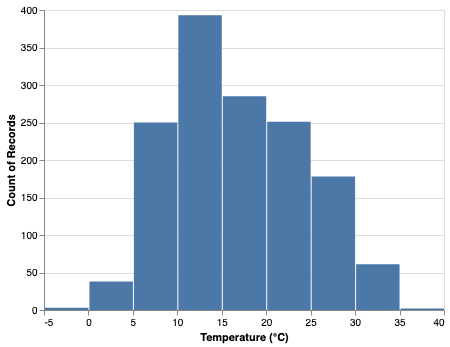

In [15]:
alt.Chart(weather).mark_bar().transform_filter(
  'datum.location == "Seattle"'
).encode(
  alt.X('temp_max:Q', bin=True, title='Temperature (°C)'),
  alt.Y('count():Q')
)

_How does this temperature profile change based on the weather of a given day – that is, whether there was drizzle, fog, rain, snow, or sun?_

Let's use the `column` encoding channel to facet the data by weather type. We can also use `color` as a redundant encoding, using a customized color range:

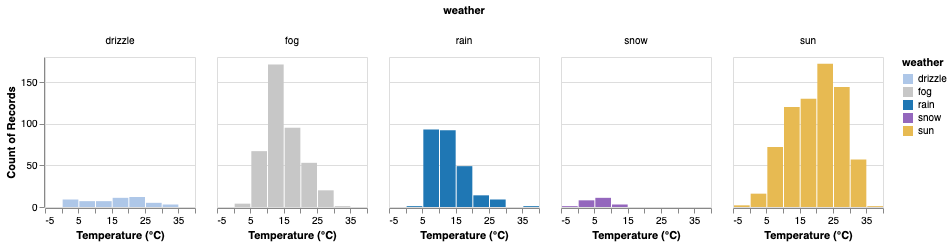

In [16]:
colors = alt.Scale(
  domain=['drizzle', 'fog', 'rain', 'snow', 'sun'],
  range=['#aec7e8', '#c7c7c7', '#1f77b4', '#9467bd', '#e7ba52']
)

alt.Chart(weather).mark_bar().transform_filter(
  'datum.location == "Seattle"'
).encode(
  alt.X('temp_max:Q', bin=True, title='Temperature (°C)'),
  alt.Y('count():Q'),
  alt.Color('weather:N', scale=colors),
  alt.Column('weather:N')
).properties(
  width=150,
  height=150
)

_Unsurprisingly, those rare snow days center on the coldest temperatures, followed by rainy and foggy days. Sunny days are warmer and, despite Seattle stereotypes, are the most plentiful. Though as any Seattleite can tell you, the drizzle occasionally comes, no matter the temperature!_

In addition to `row` and `column` encoding channels *within* a chart definition, we can take a basic chart definition and apply faceting using an explicit `facet` operator.

Let's recreate the chart above, but this time using `facet`. We start with the same basic histogram definition, but remove the data source, filter transform, and column channel. We can then invoke the `facet` method, passing in the data and specifying that we should facet into columns according to the `weather` field. The `facet` method accepts both `row` and `column` arguments. The two can be used together to create a 2D grid of faceted plots.

Finally we include our filter transform, applying it to the top-level faceted chart. While we could apply the filter transform to the histogram definition as before, that is slightly less efficient. Rather than filter out "New York" values within each facet cell, applying the filter to the faceted chart lets Vega-Lite know that we can filter out those values up front, prior to the facet subdivision.

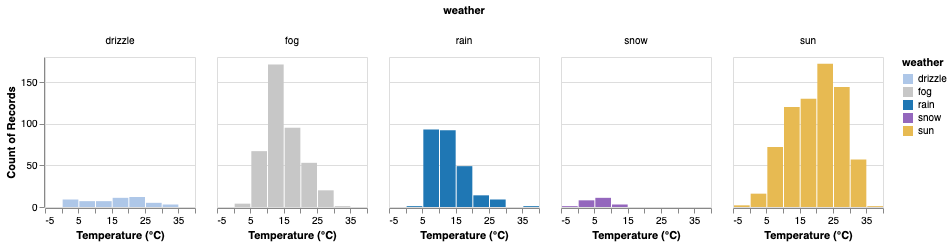

In [17]:
colors = alt.Scale(
  domain=['drizzle', 'fog', 'rain', 'snow', 'sun'],
  range=['#aec7e8', '#c7c7c7', '#1f77b4', '#9467bd', '#e7ba52']
)

alt.Chart().mark_bar().encode(
  alt.X('temp_max:Q', bin=True, title='Temperature (°C)'),
  alt.Y('count():Q'),
  alt.Color('weather:N', scale=colors)
).properties(
  width=150,
  height=150
).facet(
  data=weather,
  column='weather:N'
).transform_filter(
  'datum.location == "Seattle"'
)

Given all the extra code above, why would we want to use an explicit `facet` operator? For basic charts, we should certainly use the `column` or `row` encoding channels if we can. However, using the `facet` operator explicitly is useful if we want to facet composed views, such as layered charts.

Let's revisit our layered temperature plots from earlier. Instead of plotting data for New York and Seattle in the same plot, let's break them up into separate facets. The individual chart definitions are nearly the same as before: one area chart and one line chart. The only difference is that this time we won't pass the data directly to the chart constructors; we'll wait and pass it to the facet operator later. We can layer the charts much as before, then invoke `facet` on the layered chart object, passing in the data and specifying `column` facets based on the `location` field:

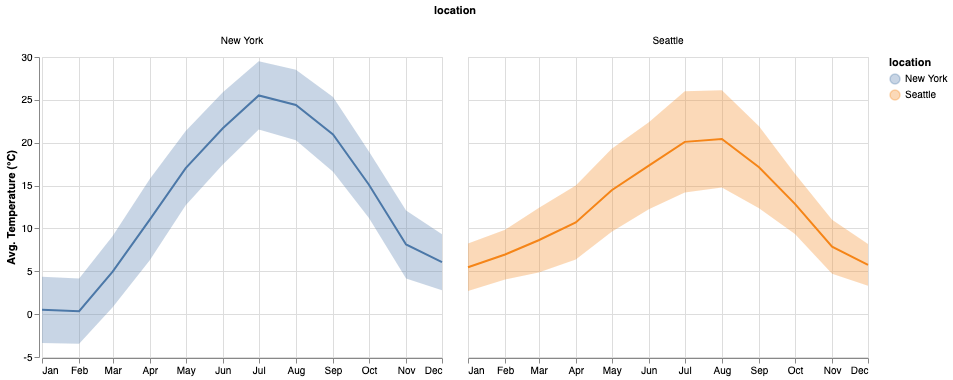

In [18]:
tempMinMax = alt.Chart().mark_area(opacity=0.3).encode(
  alt.X('month(date):T', title=None, axis=alt.Axis(format='%b')),
  alt.Y('average(temp_max):Q', title='Avg. Temperature (°C)'),
  alt.Y2('average(temp_min):Q'),
  alt.Color('location:N')
)

tempMid = alt.Chart().mark_line().transform_calculate(
  temp_mid='(+datum.temp_min + +datum.temp_max) / 2'
).encode(
  alt.X('month(date):T'),
  alt.Y('average(temp_mid):Q'),
  alt.Color('location:N')
)

alt.layer(tempMinMax, tempMid).facet(
  data=weather,
  column='location:N'
)

The faceted charts we have seen so far use the same axis scale domains across the facet cells. This default of using *shared* scales and axes helps aid accurate comparison of values. However, in some cases you may wish to scale each chart independently, for example if the range of values in the cells differs significantly.

Similar to layered charts, faceted charts also support _resolving_ to independent scales or axes across plots. Let's see what happens if we call the `resolve_axis` method to request `independent` y-axes:

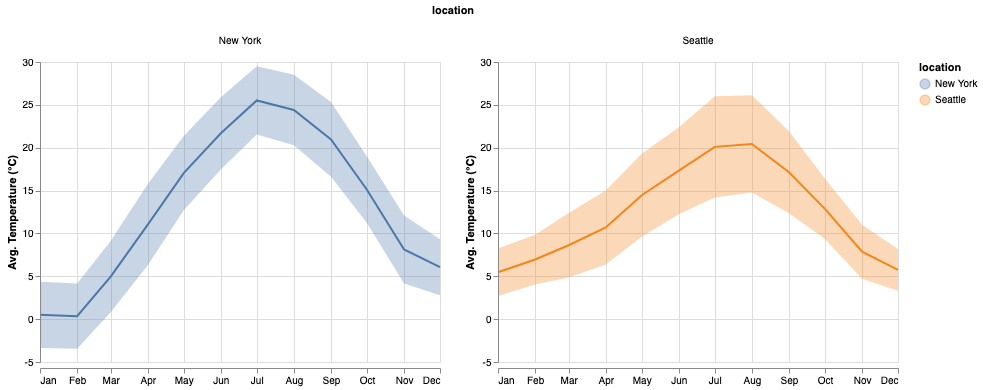

In [19]:
tempMinMax = alt.Chart().mark_area(opacity=0.3).encode(
  alt.X('month(date):T', title=None, axis=alt.Axis(format='%b')),
  alt.Y('average(temp_max):Q', title='Avg. Temperature (°C)'),
  alt.Y2('average(temp_min):Q'),
  alt.Color('location:N')
)

tempMid = alt.Chart().mark_line().transform_calculate(
  temp_mid='(+datum.temp_min + +datum.temp_max) / 2'
).encode(
  alt.X('month(date):T'),
  alt.Y('average(temp_mid):Q'),
  alt.Color('location:N')
)

alt.layer(tempMinMax, tempMid).facet(
  data=weather,
  column='location:N'
).resolve_axis(y='independent')

_The chart above looks largely unchanged, but the plot for Seattle now includes its own axis._

What if we instead call `resolve_scale` to resolve the underlying scale domains?

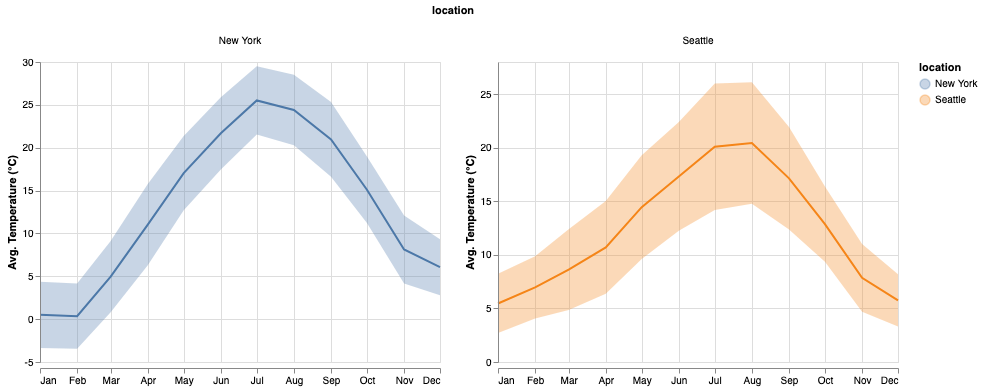

In [20]:
tempMinMax = alt.Chart().mark_area(opacity=0.3).encode(
  alt.X('month(date):T', title=None, axis=alt.Axis(format='%b')),
  alt.Y('average(temp_max):Q', title='Avg. Temperature (°C)'),
  alt.Y2('average(temp_min):Q'),
  alt.Color('location:N')
)

tempMid = alt.Chart().mark_line().transform_calculate(
  temp_mid='(+datum.temp_min + +datum.temp_max) / 2'
).encode(
  alt.X('month(date):T'),
  alt.Y('average(temp_mid):Q'),
  alt.Color('location:N')
)

alt.layer(tempMinMax, tempMid).facet(
  data=weather,
  column='location:N'
).resolve_scale(y='independent')

_Now we see facet cells with different axis scale domains. In this case, using independent scales seems like a bad idea! The domains aren't very different, and one might be fooled into thinking that New York and Seattle have similar maximum summer temperatures._

To borrow a cliché: just because you *can* do something, doesn't mean you *should*...

## Concatenate

Faceting creates [small multiple](https://en.wikipedia.org/wiki/Small_multiple) plots that show separate subdivisions of the data. However, we might wish to create a multi-view display with different views of the *same* dataset (not subsets) or views involving *different* datasets.

Altair provides *concatenation* operators to combine arbitrary charts into a composed chart. The `hconcat` operator (shorthand `|` ) performs horizontal concatenation, while the `vconcat` operator (shorthand `&`) performs vertical concatenation.

Let's start with a basic line chart showing the average maximum temperature per month for both New York and Seattle, much like we've seen before:

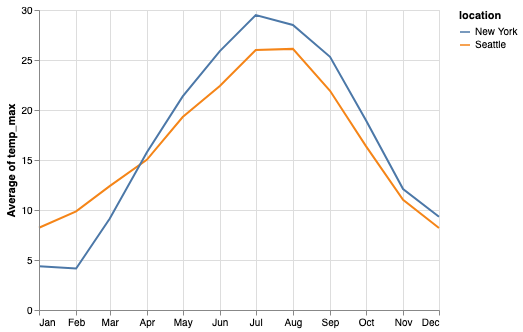

In [21]:
alt.Chart(weather).mark_line().encode(
  alt.X('month(date):T', title=None),
  alt.Y('average(temp_max):Q'),
  color='location:N'
)

_What if we want to compare not just temperature over time, but also precipitation and wind levels?_

Let's create a concatenated chart consisting of three plots. We'll start by defining a "base" chart definition that contains all the aspects that should be shared by our three plots. We can then modify this base chart to create customized variants, with different y-axis encodings for the `temp_max`, `precipitation`, and `wind` fields. We can then concatenate them using the pipe (`|`) shorthand operator:

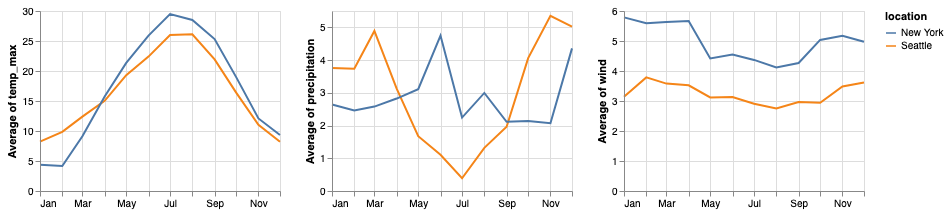

In [22]:
base = alt.Chart(weather).mark_line().encode(
  alt.X('month(date):T', title=None),
  color='location:N'
).properties(
  width=240,
  height=180
)

temp = base.encode(alt.Y('average(temp_max):Q'))
precip = base.encode(alt.Y('average(precipitation):Q'))
wind = base.encode(alt.Y('average(wind):Q'))

temp | precip | wind

Alternatively, we could use the more explicit `alt.hconcat()` method in lieu of the pipe `|` operator. _Try rewriting the code above to use `hconcat` instead._

Vertical concatenation works similarly to horizontal concatenation. _Using the `&` operator (or `alt.vconcat` method), modify the code to use a vertical ordering instead of a horizontal ordering._

Finally, note that horizontal and vertical concatenation can be combined. _What happens if you write something like `(temp | precip) & wind`?_

_Aside_: Note the importance of those parentheses... what happens if you remove them? Keep in mind that these overloaded operators are still subject to [Python's operator precendence rules](https://docs.python.org/3/reference/expressions.html#operator-precedence), and so vertical concatenation with `&` will take precedence over horizontal concatenation with `|`!

As we will revisit later, concatenation operators let you combine any and all charts into a multi-view dashboard!

## Repeat

The concatenation operators above are quite general, allowing arbitrary charts to be composed. Nevertheless, the example above was still a bit verbose: we have three very similar charts, yet have to define them separately and then concatenate them.

For cases where only one or two variables are changing, the `repeat` operator provides a convenient shortcut for creating multiple charts. Given a *template* specification with some free variables, the repeat operator will then create a chart for each specified assignment to those variables.

Let's recreate our concatenation example above using the `repeat` operator. The only aspect that changes across charts is the choice of data field for the `y` encoding channel. To create a template specification, we can use the *repeater variable* `alt.repeat('column')` as our y-axis field. This code simply states that we want to use the variable assigned to the `column` repeater, which organizes repeated charts in a horizontal direction. (As the repeater provides the field name only, we have to specify the field data type separately as `type='quantitative'`.)

We then invoke the `repeat` method, passing in data field names for each column:

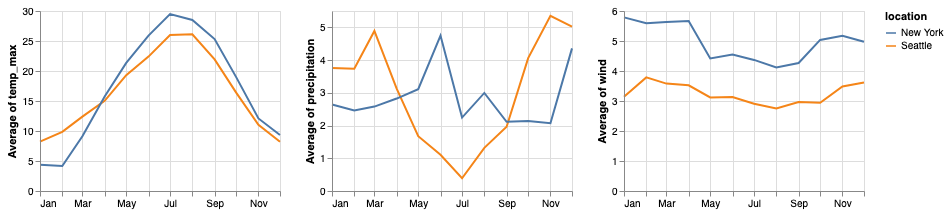

In [23]:
alt.Chart(weather).mark_line().encode(
  alt.X('month(date):T',title=None),
  alt.Y(alt.repeat('column'), aggregate='average', type='quantitative'),
  color='location:N'
).properties(
  width=240,
  height=180
).repeat(
  column=['temp_max', 'precipitation', 'wind']
)

Repetition is supported for both columns and rows. _What happens if you modify the code above to use `row` instead of `column`?_

We can also use `row` and `column` repetition together! One common visualization for exploratory data analysis is the [scatter plot matrix (or SPLOM)](https://en.wikipedia.org/wiki/Scatter_plot#Scatterplot_matrices). Given a collection of variables to inspect, a SPLOM provides a grid of all pairwise plots of those variables, allowing us to assess potential associations.

Let's use the `repeat` operator to create a SPLOM for the `temp_max`, `precipitation`, and `wind` fields. We first create our template specification, with repeater variables for both the x- and y-axis data fields. We then invoke `repeat`, passing in arrays of field names to use for both `row` and `column`. Altair will then generate the [cross product (or, Cartesian product)](https://en.wikipedia.org/wiki/Cartesian_product) to create the full space of repeated charts:

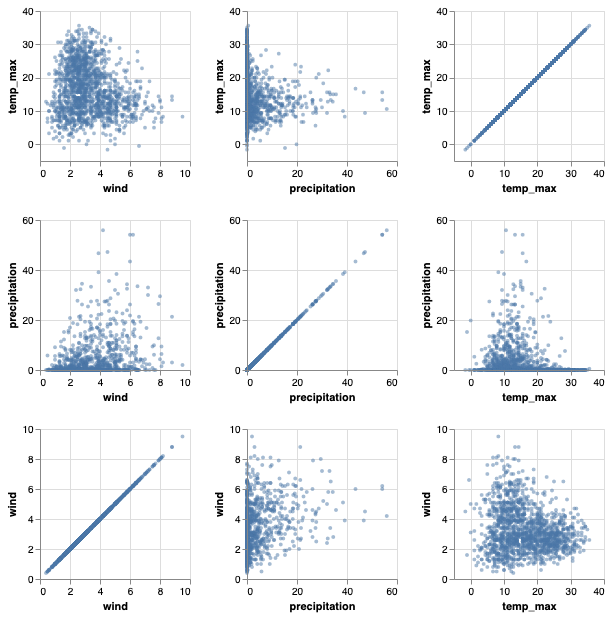

In [24]:
alt.Chart().mark_point(filled=True, size=15, opacity=0.5).encode(
  alt.X(alt.repeat('column'), type='quantitative'),
  alt.Y(alt.repeat('row'), type='quantitative')
).properties(
  width=150,
  height=150
).repeat(
  data=weather,
  row=['temp_max', 'precipitation', 'wind'],
  column=['wind', 'precipitation', 'temp_max']
).transform_filter(
  'datum.location == "Seattle"'
)

_Looking at these plots, there does not appear to be a strong association between precipitation and wind, though we do see that extreme wind and precipitation events occur in similar temperature ranges (~5-15° C). However, this observation is not particularly surprising: if we revisit our histogram at the beginning of the facet section, we can plainly see that the days with maximum temperatures in the range of 5-15° C are the most commonly occurring._

*Modify the code above to get a better understanding of chart repetition. Try adding another variable (`temp_min`) to the SPLOM. What happens if you rearrange the order of the field names in either the `row` or `column` parameters for the `repeat` operator?*

_Finally, to really appreciate what the `repeat` operator provides, take a moment to imagine how you might recreate the SPLOM above using only `hconcat` and `vconcat`!_

## A View Composition Algebra

Together, the composition operators `layer`, `facet`, `concat`, and `repeat` form a *view composition algebra*: the various operators can be combined to construct a variety of multi-view visualizations.

As an example, let's start with two basic charts: a histogram and a simple line (a single `rule` mark) showing a global average.

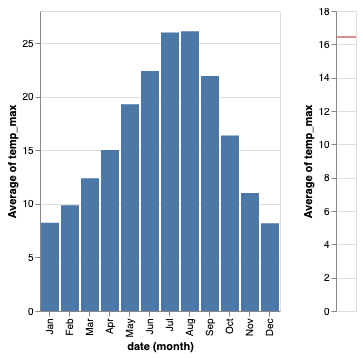

In [25]:
basic1 = alt.Chart(weather).transform_filter(
  'datum.location == "Seattle"'
).mark_bar().encode(
  alt.X('month(date):O'),
  alt.Y('average(temp_max):Q')
)

basic2 = alt.Chart(weather).transform_filter(
  'datum.location == "Seattle"'
).mark_rule(stroke='firebrick').encode(
  alt.Y('average(temp_max):Q')
)

basic1 | basic2

We can then combine the two charts using a `layer` operator, and then `repeat` that layered chart to show histograms with overlaid averages for multiple fields:

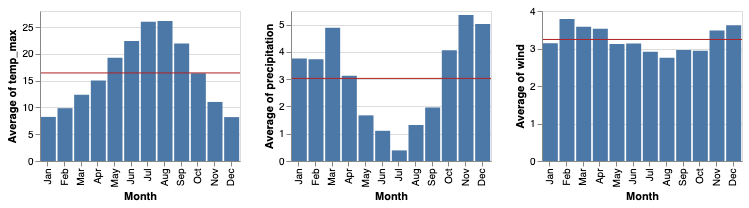

In [26]:
alt.layer(
  alt.Chart().mark_bar().encode(
    alt.X('month(date):O', title='Month'),
    alt.Y(alt.repeat('column'), aggregate='average', type='quantitative')
  ),
  alt.Chart().mark_rule(stroke='firebrick').encode(
    alt.Y(alt.repeat('column'), aggregate='average', type='quantitative')
  )
).properties(
  width=200,
  height=150
).repeat(
  data=weather,
  column=['temp_max', 'precipitation', 'wind']
).transform_filter(
  'datum.location == "Seattle"'
)

Focusing only on the multi-view composition operators, the model for the visualization above is:

```
repeat(column=[...])
|- layer
   |- basic1
   |- basic2
```

Now let's explore how we can apply *all* the operators within a final [dashboard](https://en.wikipedia.org/wiki/Dashboard_%28business%29) that provides an overview of Seattle weather. We'll combine the SPLOM and faceted histogram displays from earlier sections with the repeated histograms above:

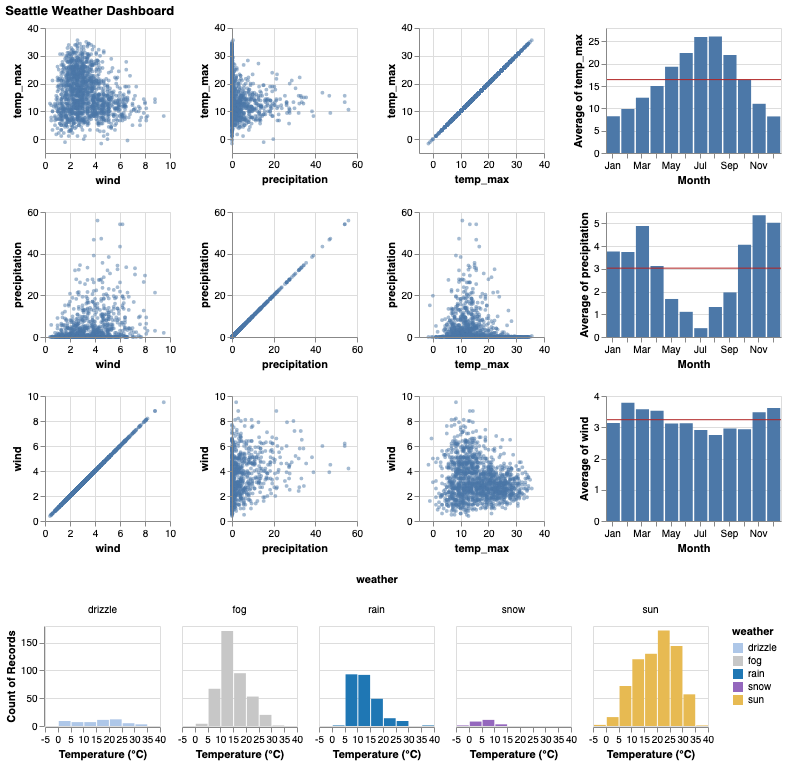

In [27]:
splom = alt.Chart().mark_point(filled=True, size=15, opacity=0.5).encode(
  alt.X(alt.repeat('column'), type='quantitative'),
  alt.Y(alt.repeat('row'), type='quantitative')
).properties(
  width=125,
  height=125
).repeat(
  row=['temp_max', 'precipitation', 'wind'],
  column=['wind', 'precipitation', 'temp_max']
)

dateHist = alt.layer(
  alt.Chart().mark_bar().encode(
    alt.X('month(date):O', title='Month'),
    alt.Y(alt.repeat('row'), aggregate='average', type='quantitative')
  ),
  alt.Chart().mark_rule(stroke='firebrick').encode(
    alt.Y(alt.repeat('row'), aggregate='average', type='quantitative')
  )
).properties(
  width=175,
  height=125
).repeat(
  row=['temp_max', 'precipitation', 'wind']
)

tempHist = alt.Chart(weather).mark_bar().encode(
  alt.X('temp_max:Q', bin=True, title='Temperature (°C)'),
  alt.Y('count():Q'),
  alt.Color('weather:N', scale=alt.Scale(
    domain=['drizzle', 'fog', 'rain', 'snow', 'sun'],
    range=['#aec7e8', '#c7c7c7', '#1f77b4', '#9467bd', '#e7ba52']
  ))
).properties(
  width=115,
  height=100
).facet(
  column='weather:N'
)

alt.vconcat(
  alt.hconcat(splom, dateHist),
  tempHist,
  data=weather,
  title='Seattle Weather Dashboard'
).transform_filter(
  'datum.location == "Seattle"'
).resolve_legend(
  color='independent'
).configure_axis(
  labelAngle=0
)

The full composition model for this dashboard is:

```
vconcat
|- hconcat
|  |- repeat(row=[...], column=[...])
|  |  |- splom base chart
|  |- repeat(row=[...])
|     |- layer
|        |- dateHist base chart 1
|        |- dateHist base chart 2
|- facet(column='weather')
   |- tempHist base chart
```

_Phew!_ The dashboard also includes a few customizations to improve the layout:

- We adjust chart `width` and `height` properties to assist alignment and ensure the full visualization fits on the screen.
- We add `resolve_legend(color='independent')` to ensure the color legend is associated directly with the colored histograms by temperature. Otherwise, the legend will resolve to the dashboard as a whole.
- We use `configure_axis(labelAngle=0)` to ensure that no axis labels are rotated. This helps to ensure proper alignment among the scatter plots in the SPLOM and the histograms by month on the right.

_Try removing or modifying any of these adjustments and see how the dashboard layout responds!_

This dashboard can be reused to show data for other locations or from other datasets. _Update the dashboard to show weather patterns for New York instead of Seattle._

## Summary

For more details on multi-view composition, including control over sub-plot spacing and header labels, see the [Altair Compound Charts documentation](https://altair-viz.github.io/user_guide/compound_charts.html).

Now that we've seen how to compose multiple views, we're ready to put them into action. In addition to statically presenting data, multiple views can enable interactive multi-dimensional exploration. For example, using _linked selections_ we can highlight points in one view to see corresponding values highlight in other views.

In the next notebook, we'll examine how to author *interactive selections* for both individual plots and multi-view compositions.